In [124]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import re
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# URL der Spielerseite
url_home = "https://swgoh.gg/"

def fun_toon_stats(url):
    # Initialisiere das Dictionary für die Ergebnisse
    ergebnisse_dict = {}
    
    # HTML-Seite abrufen
    response = requests.get(url)
    if response.status_code == 200:
        html_content = response.content
    else:
        print("Fehler beim Abrufen der Website.")
        exit()
    
    # Relevanten HTML-Code finden (gemeinsames Skript)
    soup = BeautifulSoup(html_content, "html.parser")
    
    # Finde das Skript-Tag, das die Datenpunkte für alle Diagramme enthält
    data_script = soup.find("script", string=re.compile(r"new Highcharts.Chart\({\s*chart: {\s*renderTo: 'character-stats-"))
    
    # Extrahiere den Inhalt des Skripts
    data_script_content = data_script.string
    
    # Finde alle Highcharts.Chart-Aufrufe im data_script
    chart_aufraeufe = re.findall(r"new Highcharts.Chart\({(.*?)}\)", data_script_content, re.DOTALL)
    
    # Annahme: Du hast bereits chart_aufraeufe aus dem data_script extrahiert
    for aufrauf in chart_aufraeufe:
    
         # Extrahiere den Titel aus dem Aufrauf
        title_start = aufrauf.find("title: {") + len("title: {")
        title_end = aufrauf.find("}", title_start)
        title_string = aufrauf[title_start:title_end]
    
        # Extrahiere den Text des Titels
        title_match = re.search(r"text: '(.*?)'", title_string)
        if title_match:
            diagramm_titel = title_match.group(1).split(" (Nearest ")[0]  # Entferne den Zusatz
        else:
            diagramm_titel = "Custom Diagram Title"  # Fallback-Titel, falls kein Text gefunden wird
    
            
        # Extrahiere die Datenpunkte aus dem String
        data_start = aufrauf.find("data: [") + len("data: [")
        data_end = aufrauf.find("]", data_start)
        data_string = aufrauf[data_start:data_end]
    
        # Teile den data_string in einzelne Datenpunkte auf
        datenpunkte = data_string.split("},\n")
    
        # Extrahiere x- und y-Wertepaare
        x_werte = []
        y_werte = []
        for punkt in datenpunkte:
            x_start = punkt.find("x:") + len("x:")
            x_end = punkt.find(",", x_start)
            x = punkt[x_start:x_end].strip()
    
            y_start = punkt.find("y:") + len("y:")
            y_end = punkt.find(",", y_start)
            y = punkt[y_start:y_end].strip()
    
            if x:  # Prüfe, ob der x-Wert nicht leer ist
                x_werte.append(float(x))
            if y:  # Prüfe, ob der y-Wert nicht leer ist
                y_werte.append(float(y))  # Ändere y zu float
        
        # Berechne den gewichteten Mittelwert und die gewichtete Standardabweichung
        x_array = np.array(x_werte)
        y_array = np.array(y_werte)
        gewichteter_mittelwert = np.average(x_array, weights=y_array)
        gewichtete_std = np.sqrt(np.average((x_array - gewichteter_mittelwert) ** 2, weights=y_array))
        # Berechne das Verhältnis SD/Mean
    
        # Speichere die Ergebnisse im Dictionary
        ergebnisse_dict[diagramm_titel] = [gewichteter_mittelwert, gewichtete_std]
    
    # Gib das Ergebnis aus
    return ergebnisse_dict

def fun_toon_base(url):
    # HTML-Seite abrufen
    response = requests.get(url)
    if response.status_code == 200:
        html_content = response.content
    else:
        print("Fehler beim Abrufen der Website.")
        exit()
    
    # Relevanten HTML-Code finden (gemeinsames Skript)
    soup = BeautifulSoup(html_content, "html.parser")
    
    # Angenommen, du hast bereits die 'soup' mit den Daten
    # Finde das 'window.unit_data_lookup'-Objekt
    unit_data_lookup_script = soup.find("script", string=re.compile(r"window.unit_data_lookup"))
    if unit_data_lookup_script:
        # Extrahiere den Textinhalt des Skripts
        unit_data_lookup_text = unit_data_lookup_script.text
    
        # Suche nach dem GEAR_13-Teil im 'window.unit_data_lookup'
        gear_13_start = unit_data_lookup_text.find("GEAR_13:")
        if gear_13_start != -1:
            gear_13_text = unit_data_lookup_text[gear_13_start:]
    
            # Extrahiere die relevanten Werte
            relevant_values = ["Health", "Speed", "Protection", "Tenacity", "Potency", "Armor", "Resistance"]
            gear_13_data = {}
            for value in relevant_values:
                value_start = gear_13_text.find(f'"label": "{value}"')
                if value_start != -1:
                    # Suche nach dem Wert für "value"
                    value_value_start = gear_13_text.find('"value": ', value_start)
                    value_value_end = gear_13_text.find(",", value_value_start)
                    value_str = gear_13_text[value_value_start + len('"value": '):value_value_end]
                    try:
                        gear_13_data[value] = float(value_str)  # Wir verwenden float, da einige Werte Dezimalstellen haben
                    except ValueError:
                        print(f"Ungültiger Wert für {value}: {value_str}")
                else:
                    print(f"{value} nicht gefunden.")
            for section in ["Physical Offense", "Special Offense"]:
                section_start = gear_13_text.find(f'"label": "{section}"')
                if section_start != -1:
                    # Suche nach dem Wert für "Damage"
                    damage_start = gear_13_text.find('"label": "Damage"', section_start)
                    if damage_start != -1:
                        damage_value_start = gear_13_text.find('"value": ', damage_start)
                        damage_value_end = gear_13_text.find(",", damage_value_start)
                        damage_str = gear_13_text[damage_value_start + len('"value": '):damage_value_end]
                        try:
                             gear_13_data["Attack Damage" if section == "Physical Offense" else "Special Damage"] = float(damage_str)
                        except ValueError:
                            print(f"Ungültiger Wert für {section} Damage: {damage_str}")
                    else:
                        print(f"Damage für {section} nicht gefunden.")
                else:
                    print(f"{section} nicht gefunden.")
    
            
        else:
            print("GEAR_13 nicht gefunden.")
    else:
        print("window.unit_data_lookup nicht gefunden.")
    
    return gear_13_data

def fun_toon_player(url):
    # HTML-Seite abrufen
    response = requests.get(url)
    if response.status_code == 200:
        html_content = response.content
    else:
        print("Fehler beim Abrufen der Website.")
        exit()
    
    # Relevanten HTML-Code finden
    soup = BeautifulSoup(html_content, "html.parser")
    
    # Extrahiere die Werte
    def extract_stat(label):
        stat_element = soup.find("span", class_="unit-stat-group-stat-label", string=label)
        if stat_element:
            value_element = stat_element.find_next("span", class_="unit-stat-group-stat-value")
            if value_element:
                value_text = value_element.text.strip()
                # Extrahiere den Wert (ohne Ausrüstung)
                value = value_text.split("(")[0].replace(",", "").strip()  # Entferne Tausendertrennzeichen
                if "%" in value:
                    # Prozentwert in Fließkommazahl umwandeln
                    value = float(value.replace("%", ""))
                    if label in ["Tenacity", "Potency"]:
                        value /= 100  # Teile durch 100
                else:
                    value = float(value)
                return value
        return None
    
    # Daten in einer Dictionary-Struktur speichern
    data = {
        "Health": extract_stat("Health"),
        "Speed": extract_stat("Speed"),
        "Protection": extract_stat("Protection"),
        "Tenacity": extract_stat("Tenacity"),
        "Potency": extract_stat("Potency"),
        "Armor": extract_stat("Armor"),
        "Resistance": extract_stat("Resistance"),
        "Attack Damage": extract_stat("Physical Damage"),
        "Special Damage": extract_stat("Special Damage")
    }
    
    return data

def get_toon_score(player_id, toon):
    
    # Kombiniere die Basis-URL mit dem relativen Pfad zum Charakter
    url_toon_player = urljoin(url_home, f"p/{player_id}/characters/{toon}")
    url_toon_base = urljoin(url_home, f"characters/{toon}") 
    url_toon_stats = urljoin(url_home, f"characters/{toon}/data/stats?filter_type=guild_100_gp") 
            
    toon_stats = fun_toon_stats(url_toon_stats)    
    toon_base = fun_toon_base(url_toon_base)   
    toon_player = fun_toon_player(url_toon_player)
    
    # Führen Sie die Einträge aus toon_base und toon_player in toon_stats zusammen
    for key in toon_stats:
        toon_stats[key].append(toon_base[key])
        toon_stats[key].append(toon_player[key])
    
    gewichte = []
    wertung = []
    
    for key in toon_stats:
        values = toon_stats[key]
        
        gewichte.append( (values[0] - values[2])/(values[2] + values[0]) )
        wertung.append( (values[3] - values[0])/(values[1] + 0) )
    
    gewichte = np.array(gewichte)
    gewichte = gewichte/np.sum(gewichte)
    wertung = np.array(wertung)
    
    scores = gewichte*wertung
    
    score = np.sum(scores)

    return score

def fun_get_toon_list(player_id):

    url_player = urljoin(url_home, f"p/{player_id}/characters/")
    
    # HTML-Seite abrufen
    response = requests.get(url_player)
    if response.status_code == 200:
        html_content = response.content
    else:
        print("Fehler beim Abrufen der Website.")
        exit()
    
    # Relevanten HTML-Code finden
    soup = BeautifulSoup(html_content, "html.parser")
    
    # Dictionary für die Charaktere erstellen
    toons = {}
    
    # Alle Charaktere durchgehen
    for char_div in soup.find_all("div", class_="collection-char"):
        char_name = char_div["data-name-lower"]
        char_url = char_div.find("a")["href"]
        if char_div.find("div", class_="character-portrait__rframe"):
            # Charakter hat Reliktstufe erreicht
            char_url_parts = char_url.split("/")
            char_url_name = char_url_parts[-1]
            toons[char_name] = char_url_name

    return toons


def get_toon_weight(toon):
    
    # Kombiniere die Basis-URL mit dem relativen Pfad zum Charakter
    url_toon_base = urljoin(url_home, f"characters/{toon}") 
    url_toon_stats = urljoin(url_home, f"characters/{toon}/data/stats?filter_type=guild_100_gp") 
            
    toon_stats = fun_toon_stats(url_toon_stats)    
    toon_base = fun_toon_base(url_toon_base)   
    
    # Führen Sie die Einträge aus toon_base und toon_player in toon_stats zusammen
    for key in toon_stats:
        toon_stats[key].append(toon_base[key])
    
    gewichte = []
    
    for key in toon_stats:
        values = toon_stats[key]
        
        gewichte.append( (values[0] - values[2])/(values[2] + values[0]) )
    

    return np.sum(gewichte)

def fun_weights(url):

    # HTML-Seite abrufen
    response = requests.get(url)
    if response.status_code == 200:
        html_content = response.content
    else:
        print("Fehler beim Abrufen der Website.")
        exit()

    # Relevanten HTML-Code finden (gemeinsames Skript)
    soup = BeautifulSoup(html_content, "html.parser")

    # Alle Charaktere extrahieren
    character_entries = soup.find_all("li", class_="media list-group-item p-0 character")

    # Wörterbuch für Charaktere erstellen
    character_dict = {}
    for entry in character_entries:
        name = entry["data-name-lower"]  # Hier ändern wir die Quelle für den Namen
        tag = entry.find("a")["href"].split("/")[-2]  # Extrahiere den Tag aus der URL
        character_dict[name] = tag

    for key in character_dict.keys():
        toon = character_dict[key]
        score = get_toon_weight(toon)
        character_dict[key] = score
        #print(f"{key}: {score}")

    values = np.array(list(character_dict.values()))
    #vMin = np.amin(values)
    nVal = len(values)
    values[values < 0] = 0
    #values = values - vMin
    values = values / np.sum(values) * nVal
    for v, toon in zip(values, character_dict.keys()):
        character_dict[toon] = v
    
    return character_dict

def fun_get_awesomeness(player_id, weights):
    
    toon_list = fun_get_toon_list(player_id)

    for name, url_name in toon_list.items():
        score = get_toon_score(player_id, url_name)
        toon_list[name] = score
        
    # DataFrame erstellen
    df = pd.DataFrame(toon_list.items(), columns=["Character", "Toon-Score"])

    # Berechnungen hinzufügen
    df["Weighting"] = df["Character"].map(weights)
    df["Awesomeness"] = df["Toon-Score"] * df["Weighting"]

    # Sortieren nach Awesomeness (absteigend)
    df.sort_values(by="Awesomeness", ascending=False, inplace=True)
    
    return df

In [82]:
weights = fun_weights(url_home)

In [128]:
player_id = "559143933" #KoCa
#player_id = "859954944" #TrueSway

df = fun_get_awesomeness(player_id, weights)
# Ergebnis anzeigen

print(df.to_string(index=False))


                     Character  Toon-Score  Weighting  Awesomeness
                      cad bane    0.839457   1.286174     1.079688
                          embo    0.658954   1.261284     0.831128
                         kuiil    1.043067   0.769110     0.802233
     boba fett, scion of jango    0.618608   1.097986     0.679222
                 tusken shaman    0.821100   0.760395     0.624360
                         ig-11    0.678601   0.860207     0.583737
                    paz vizsla    0.519700   1.051691     0.546564
                   baze malbus    0.505910   0.842797     0.426380
              tusken chieftain    0.595113   0.681750     0.405719
                   urorrur'r'r    0.397655   1.007335     0.400572
                    mon mothma    0.386264   1.011510     0.390709
      first order sf tie pilot    0.381600   1.022505     0.390188
              resistance pilot    0.381789   1.018131     0.388711
                tusken warrior    0.555205   0.695323     0.38

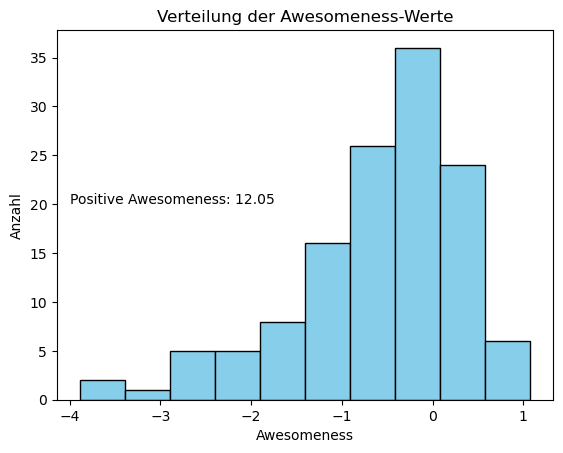

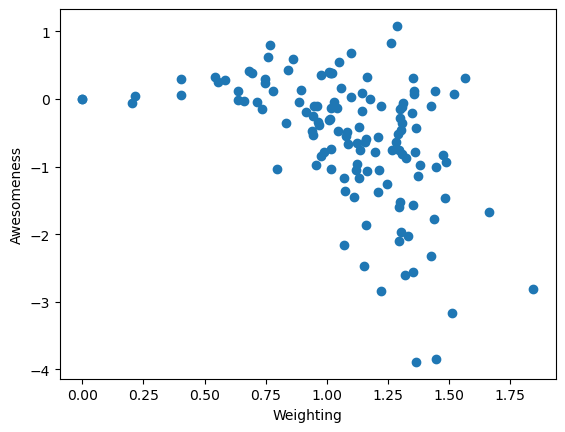

In [132]:
# Histogramm erstellen
plt.hist(df["Awesomeness"], bins=10, color="skyblue", edgecolor="black")
plt.xlabel("Awesomeness")
plt.ylabel("Anzahl")
plt.title("Verteilung der Awesomeness-Werte")

# Summe der positiven Awesomeness-Werte
positive_awesomeness_sum = df[df["Awesomeness"] > 0]["Awesomeness"].sum()
plt.text(-4, 20, f"Positive Awesomeness: {positive_awesomeness_sum:.2f}", fontsize=10)

plt.show()


plt.scatter(df["Weighting"], df["Awesomeness"])
plt.xlabel("Weighting")
plt.ylabel("Awesomeness")

plt.show()

In [234]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import pandas as pd

# URL der Spielerseite
url_home = "https://swgoh.gg/"
guild = "0f2MDLSaTn-4gRsbvd8ReQ"

weights = fun_weights(url_home)


url = urljoin(url_home, f"g/{guild}/")

# Initialisiere das Dictionary für die Ergebnisse
ergebnisse_dict = {"Spieler": [], "ID": [], "GP": [], "PSR": [], "Awesomeness": []}

# HTML-Seite abrufen
response = requests.get(url)
if response.status_code == 200:
    html_content = response.content
else:
    print("Fehler beim Abrufen der Website.")
    exit()

# Relevanten HTML-Code finden (gemeinsames Skript)
soup = BeautifulSoup(html_content, "html.parser")

# Alle Spieler-Informationen extrahieren
spieler_liste = soup.find_all("td", {"data-sort-value": re.compile(r".*")})
for spieler in spieler_liste:
    spieler_name_element = spieler.find("strong")
    if spieler_name_element:
        spieler_name = spieler_name_element.text
        spieler_id = spieler.find("a")["href"].split("/p/")[-1].split("/")[0]
        spieler_gp = spieler.find_next("td").text.split(" - ")[0]  # Extrahiere GP
        spieler_psr = spieler.find_next("td", {"data-sort-value": re.compile(r".*")}).text.split(" - ")[0]  # Extrahiere PSR
        ergebnisse_dict["Spieler"].append(spieler_name)
        ergebnisse_dict["ID"].append(spieler_id)
        ergebnisse_dict["GP"].append(spieler_gp)
        ergebnisse_dict["PSR"].append(spieler_psr.strip())  # Entferne Leerzeichen am Anfang
        # Entferne das "\n" aus dem PSR
        if ergebnisse_dict["PSR"][-1].startswith("\n"):
            ergebnisse_dict["PSR"][-1] = ergebnisse_dict["PSR"][-1][1:]
        
        # Berechne den Wert für Awesomeness (Beispiel: f(id) = id * 2)
        df = fun_get_awesomeness(spieler_id, weights)
        
        awesomeness_value = df[df["Awesomeness"] > 0]["Awesomeness"].sum()
        ergebnisse_dict["Awesomeness"].append(awesomeness_value)
        # Erstelle einen DataFrame mit der aktuellen Zeile
        spieler_df = pd.DataFrame(ergebnisse_dict)
        # Gib die Zeile aus
        print(spieler_df.iloc[-1])

# DataFrame erstellen
spieler_df = pd.DataFrame(ergebnisse_dict)



Spieler        Thunderstorm
ID                867747563
GP                  6901640
PSR                    2247
Awesomeness        1.379717
Name: 0, dtype: object
Spieler        Spacebear
ID             883415444
GP               7179850
PSR                 2808
Awesomeness     5.888919
Name: 1, dtype: object
Spieler            Janko
ID             113931371
GP               7821689
PSR                 3293
Awesomeness     3.703742
Name: 2, dtype: object
Spieler            Brasi
ID             328221927
GP               7816630
PSR                 2675
Awesomeness     3.230656
Name: 3, dtype: object
Spieler            Kayne
ID             426948932
GP               6509731
PSR                 2620
Awesomeness     1.876359
Name: 4, dtype: object
Spieler        Shadowcat
ID             656848841
GP               7953687
PSR                 3076
Awesomeness     6.589955
Name: 5, dtype: object
Spieler             KoCa
ID             559143933
GP               8073195
PSR                 32

In [241]:


pd.set_option("display.max_rows", None)
spieler_df.sort_values(by="Awesomeness", ascending=False, inplace=True)
print(spieler_df.to_string(index=False))


       Spieler        ID       GP  PSR  Awesomeness
        Sulaco 382771759 10928680 3523    21.321989
          KoCa 559143933  8073195 3233    12.053055
 Barbar 241006 654295495  5624065 2514     7.455926
        Skaarj 219816593  8236724 3163     7.397362
     Shadowcat 656848841  7953687 3076     6.589955
        Jiffsy 887999758  8897644 2919     6.056657
     Spacebear 883415444  7179850 2808     5.888919
  BARBAR241006 693593546  5111521 2511     5.676958
  hansibucka91 266265658  5429985 2444     4.798958
  Schildwall98 866844396  6434306 2453     3.956908
    LinkBuffon 837841492  5095468 2278     3.919273
         Lordi 937651321  5942612 2515     3.809960
         Janko 113931371  7821689 3293     3.703742
      Bobalice 435947987  6232390 2524     3.528618
         Brasi 328221927  7816630 2675     3.230656
      TrueSway 859954944  6166938 2794     3.022356
 darthüberbozz 199549173  5496866 2489     2.834709
        TCaD87 494773483  8125793 3066     2.804900
          Wa

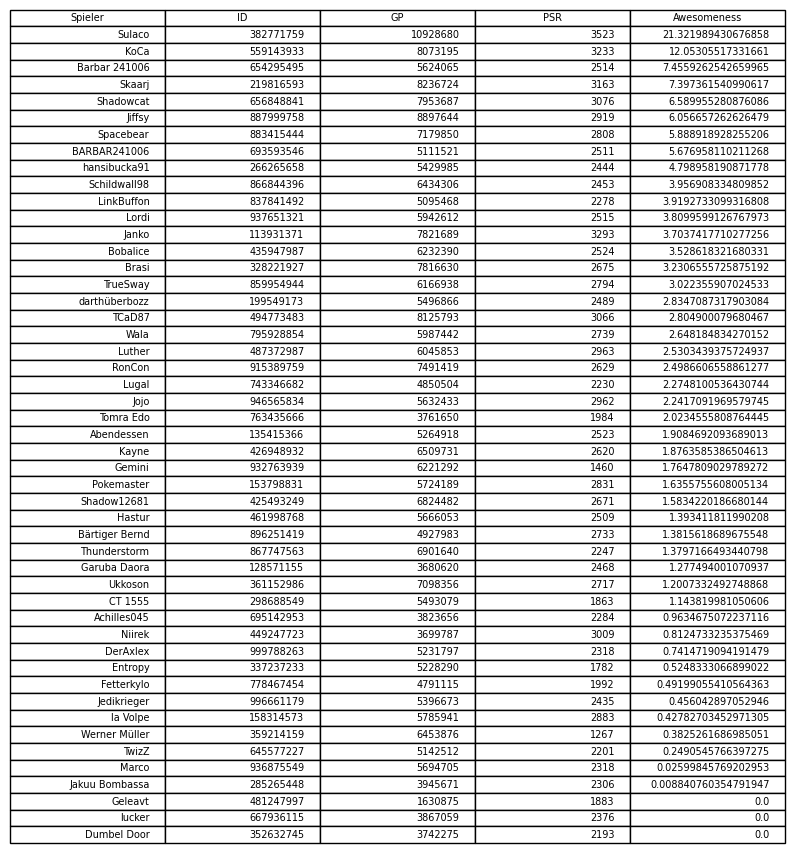

In [292]:
# Tabelle mit Matplotlib erstellen
fig, ax = plt.subplots(figsize=(10, 10))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=spieler_df.values, colLabels=spieler_df.columns, loc='center')

# PNG-Datei speichern
plt.savefig('dataframe.png', dpi = 600)

